# Introduction to time series analysis

This notebook provides an overview of time series analysis. Time series are a very common type of data. Applications of time series analysis include:

- **Demand forecasting:** electricity production, internet bandwidth, traffic management, inventory management
- **Medicine:** time dependent treatment effects, IoT monitoring devices
- **Engineering and science:** signal analysis, analysis of physical processes
- **Capital markets and economics:** seasonal unemployment, risk analysis, financial analysis


What sets **time series data** apart from the kind of data we have been dealing with so far (sometimes referred to as **cross-sectional data** Cross-sectional data is a type of observational dataset where variables are collected from multiple subjects (e.g., individuals, companies, countries) at a single point in time. Unlike time-series or panel data, it does not track changes over time.
📋 Key Characteristics
✅ Snapshot in Time – Captures data at one moment (e.g., "2024 Customer Survey").
✅ No Time Dimension – Unlike longitudinal data, it doesn’t track trends.
✅ Used for Comparisons – Helps compare different groups (e.g., income levels by region in 2024).) is that in time series data, we are really only interested in predictions *beyond the range* of available data. This means that we look at the past not so much to model the past, but rather to predict the future, which we also call **forecasting**. We say that forecasting is a type of **extrapolation**, whereas in predicting in general is usually a type of **interpolation**. Of course we may also need to extrapolate with cross-sectional data, but with time series data extrapolation is the rule, not the exception. As we will see, in practice, many of the methods we learned for linear regression can still be employed here, but with some modification.





We will work with a data set which shows the consumption of chocolate, beer and electricity in Australia from 1958 to 1991.

In [45]:
from math import sin, pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as nr

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

import warnings
warnings.filterwarnings('ignore')

def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x=x.index,y=x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

In [ ]:
from math import sin, pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as nr

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

import warnings
warnings.filterwarnings('ignore')

def decomp_ts(ts, period, model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model, period = period)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x=x.index,y=x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

In [46]:
CBE = pd.read_csv('cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')

CBE.head()

,choc,beer,elec
1958-01-31,1451,96.3,1497
1958-02-28,2037,84.4,1463
1958-03-31,2477,91.2,1648
1958-04-30,2785,81.9,1595
1958-05-31,2994,80.5,1777


We limit our example to looking at beer consumption.

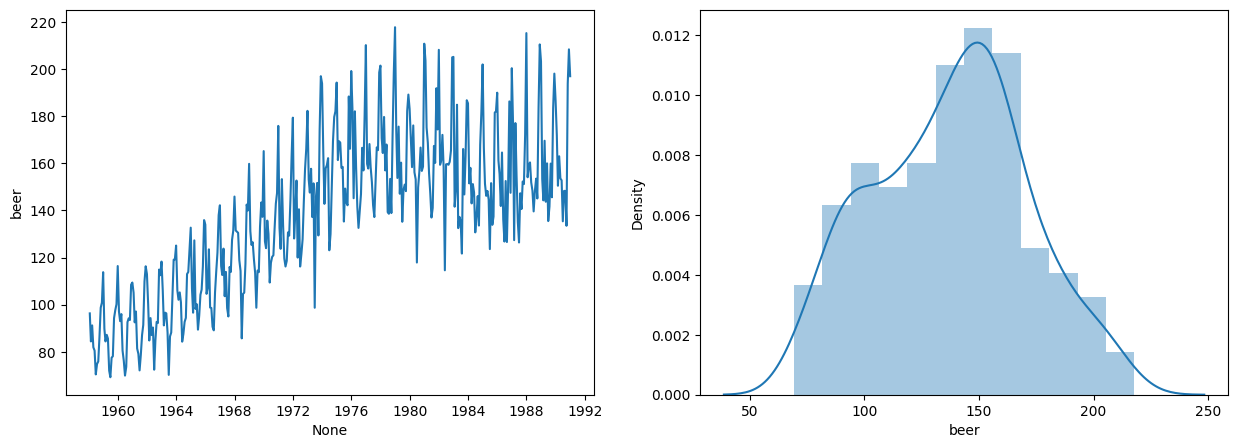

In [47]:
plot_ts_resid(CBE['beer'])

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. Seeing this situation indicates that we should use a **multiplicative decomposition model**.  

The multiplicative model can be easily transformed to an additive model by taking the logarithm of the values.

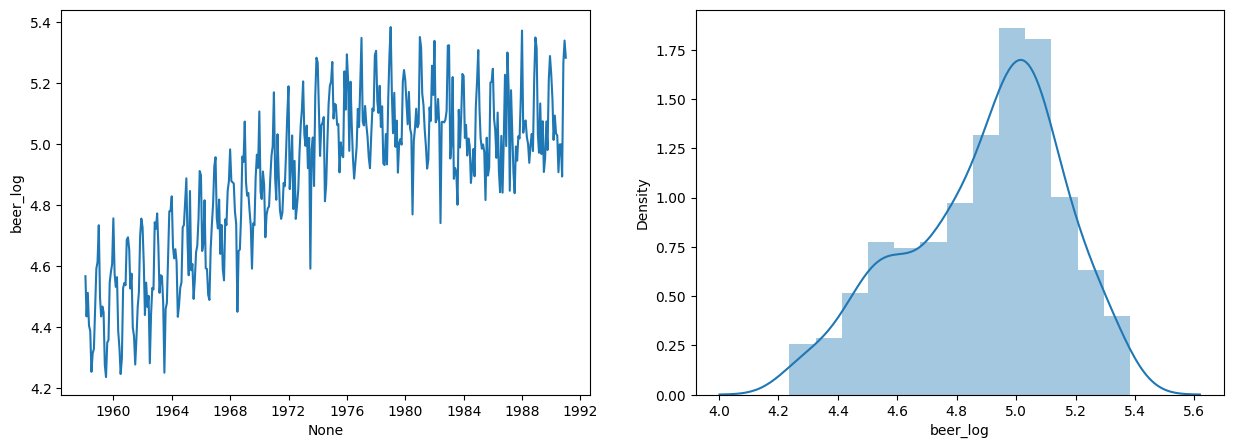

In [48]:
CBE['beer_log'] = np.log(CBE['beer'])
plot_ts_resid(CBE['beer_log'])

Trend appears as an overall upward or downward movement.
Seasonality appears as repeating patterns (yearly, monthly, weekly, etc.).



Notice the following properties about this time series.
- It has a significant trend.
- The time series have a noticeable seasonal component.
- The magnitude of the seasonal component increases with trend in the un-transformed time series. 
- The seasonal component of the log transformed series has a nearly constant magnitude, but decreases a bit with time. 

These results indicate that an STL decomposition is required. Further, a multiplicative (log transformed) STL model is preferred.


### Fitting linear regression

Before training any time series model, let's see how our old fried linear regression does. In cases where the data is relatively well behaved, we can train a model using linear regression, but we need to do some pre-processing to account for the time series nature of the data. This can be a manual and laborious process, but going through it can give us a sense of what trying to model time series "manually" looks like.

- Create a feature called `month_int`, which is equal to 1 when the month is January, 2 for February, and so on. Create another feature called `month_sqr` which is the square of `month_int`. <span style="color:red" float:right></span>
- One-hot-encode the `month_int` feature (creating one binary feature for each month), and normalize `month_int` and `month_sqr`. <span style="color:red" float:right></span>
- Create a feature called `beer_log_lag_1` which is the first lag of `beer_log` (as in the last known price of beer, when you look at the previous row). HINT: You can get lagged features using the `shift` method. <span style="color:red" float:right></span>

In [49]:
## your code goes here

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
CBE.info()
CBE.index = pd.to_datetime(CBE.index)
CBE['month_int'] = CBE.index.month

CBE['month_sqr']=CBE['month_int']**2
encoder = OneHotEncoder(sparse_output=False)
month_encoded = encoder.fit_transform(CBE[['month_int']])
print("shape of month_encoded",month_encoded.shape)

encoded_df = pd.DataFrame(month_encoded, columns=encoder.get_feature_names_out(['month_int']),index=CBE.index)
CBE=pd.concat([CBE,encoded_df],axis=1)
CBE['month_int']=StandardScaler().fit_transform(CBE[['month_int']])
CBE['month_sqr']=StandardScaler().fit_transform(CBE[['month_sqr']])
CBE['beer_log_lag_1']=CBE['beer_log'].shift(1)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1958-01-31 to 1990-12-31
Freq: ME
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   choc      396 non-null    int64  
 1   beer      396 non-null    float64
 2   elec      396 non-null    int64  
 3   beer_log  396 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.5 KB
shape of month_encoded (396, 12)


In [50]:
CBE.dropna(subset=['beer_log_lag_1'],inplace=True)

With the feature engineering steps we took, we should be able to train a linear regression model now. With `month_int` and `month_sqr` the model should be able to find a trend over the course of the year, which is either linear or curvelinear with a single peak or trough. By one-hot-encoding `month_int` the model can also capture month to month effects. Finally, using a lagged feature, the model can anchor its beer price prediction on the last known price.

- Split the data into training and test sets, using the last 12 months of data for testing. <span style="color:red" float:right></span> 
- Train a linear regression model to predict beer price using onely the features we created earlier. <span style="color:red" float:right></span> 

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## your code goes here
CBE_new=CBE.copy()
X=CBE_new.drop(columns=['beer'])
y=CBE_new['beer']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

ls=LinearRegression()
ls.fit(X,y)
CBE['beer_predicted']=ls.predict(X)
CBE.tail()

,choc,beer,elec,beer_log,month_int,month_sqr,month_int_1,month_int_2,month_int_3,month_int_4,month_int_5,month_int_6,month_int_7,month_int_8,month_int_9,month_int_10,month_int_11,month_int_12,beer_log_lag_1,beer_predicted
1990-08-31,8715,148.3,14338,4.999237,0.434524,0.213308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.999237,150.083844
1990-09-30,8450,133.5,12867,4.894101,0.724207,0.582078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.999237,135.174948
1990-10-31,9085,193.8,12761,5.266827,1.013890,0.994232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.894101,187.602577
1990-11-30,8350,208.4,12449,5.339459,1.303572,1.449771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.266827,196.209845
1990-12-31,7080,197.0,12658,5.283204,1.593255,1.948695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.339459,191.430867


- Plot a line plot of the original time series, and to the same plot add line plots to show the predictions on the training data and the test data. Use separate colors for each. <span style="color:red" float:right></span> 

<Axes: xlabel='None', ylabel='beer'>

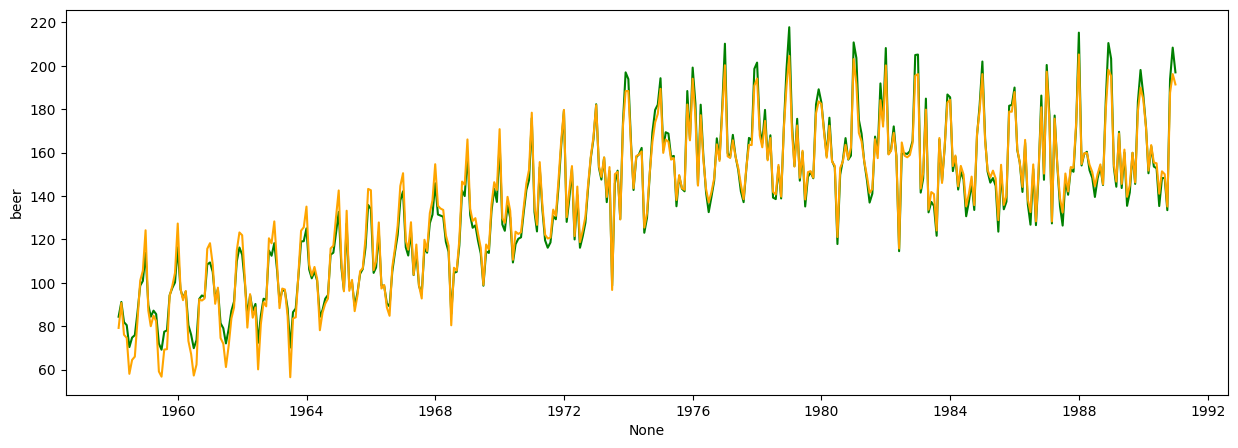

In [52]:
## your code goes here
sns.lineplot(x=CBE.index,y=CBE['beer'],color='green')
sns.lineplot(x=CBE.index,y=CBE['beer_predicted'],color='orange')

- Compute the **root mean square error (RMSE)** of the model on the test data and plot the line plot and the histogram of the residual (beer price minus forecast) using the `plot_ts_resid` helper function. What conclusion would you draw about the model we fit? <span style="color:red" float:right></span> 

RMSE value  is 4.7751


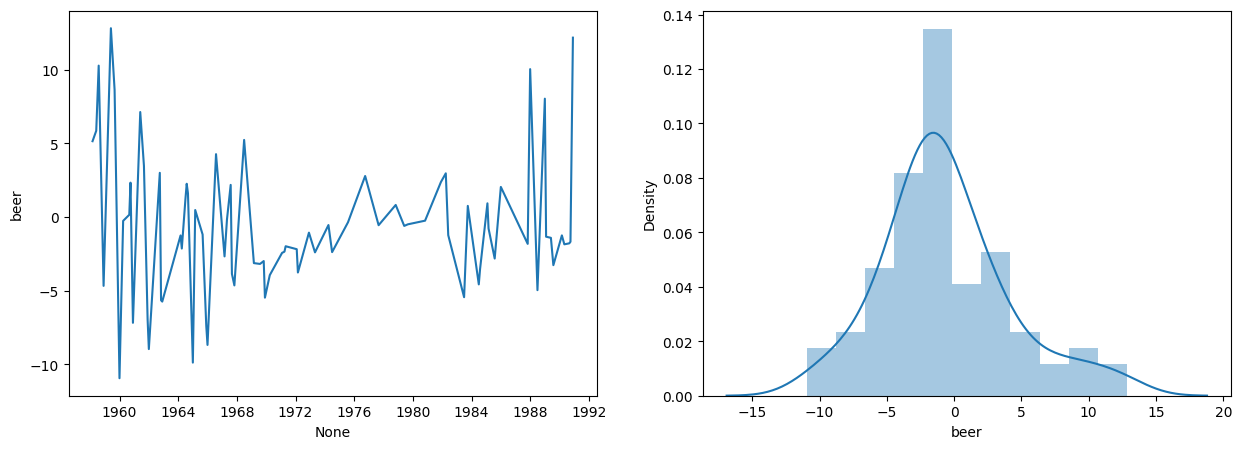

In [69]:
from sklearn.metrics import mean_squared_error
from math import sqrt

## your code goes here

y_pred=ls.predict(X_test)
rmse_vl=sqrt(mean_squared_error(y_test,y_pred))
print(f"RMSE value  is {rmse_vl:.4f}")

residuals=y_test-y_pred
# CBE['beer']-CBE['beer_predicted']
plot_ts_resid(residuals)

could See that model has  seasonality , Trend and Residual .

### Fitting a time series model

Let's now try the models we learned about in this lesson. By doing so, we can later compare the two approaches and appreciate the pros and cons.

- Use the `decomp_ts` helper function to decompose `beer_log`. Remove the NAs from the data, then use the `plot` method to plot a line plot of the components. <span style="color:red" float:right></span> 

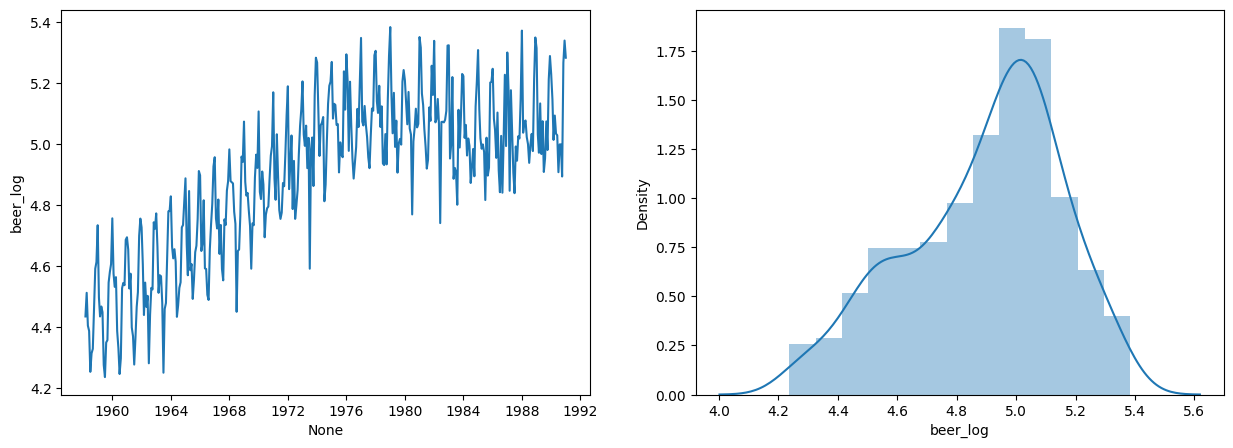

In [54]:
## your code goes here
CBE =CBE[CBE.notna()] 
decomp = decomp_ts(CBE['beer_log'], period = 12)

plot_ts_resid(CBE['beer_log'])

- Compute and plot the ACF and PACF for the remainder (residual) series, up to 36 lags. <span style="color:red" float:right></span>

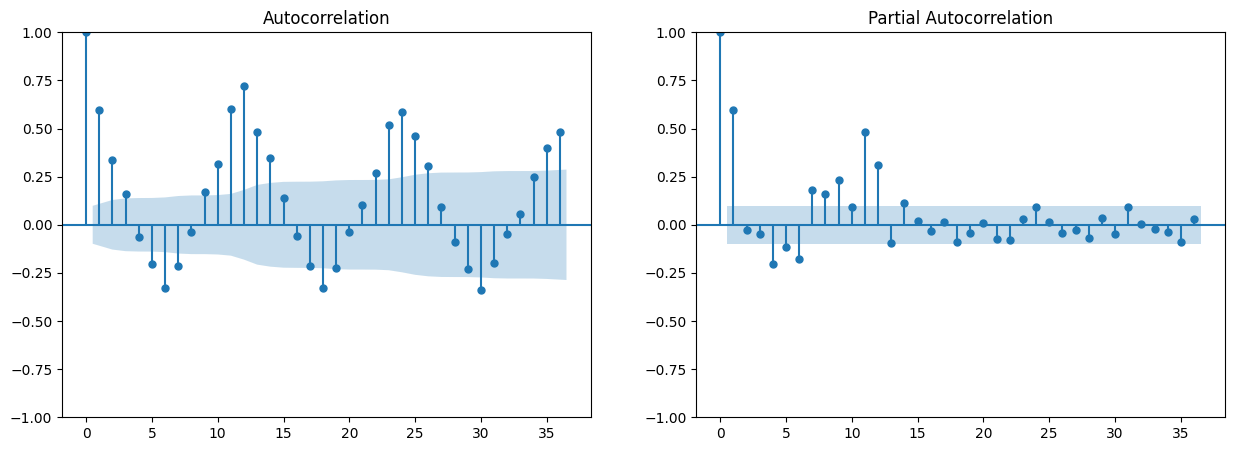

In [55]:
## your code goes here
plot_acf_pacf(residuals, lags = 36)

As you can imagine, with real data things can look very messy. The ACF and PACF can exhibit both AR and MA behavior and it's hard to know what degrees to choose. So we will use the `auto_arima` function to help us: It  iterates over a grid of $(p, d, q)$ and seasonal $(P, D, Q)$ values. For each combination the BIC is computed and compared to the best previous model. For each combination the BIC is computed and compared to the best previous model. The better model is the one with the lowest BIC: The **Bayesian information criteria (BIC)** is a measure for assessing a model's fit:

$$
\begin{align}
\text{BIC} &= \ln(n)k - 2 \ln(\hat L)
\end{align}
$$

where $\hat L$ is the likelihood of the data given the fitted model parmaters, $k$ is the number of model parameters, and $n$ is the number of observations. Lower values for BIC means we have a better fit.

The code below implements `auto_arima`. As you can see, we provide it with the data, some maximum value for the hyper-pramaters $(p, d, q)$ and $(P, D, Q)$. It's very unusual to choose a number greater than 3. Run the next cell and examine the results. The function returns the best model, i.e. the model whose hyper-parameters gave the lowest BIC.

ADF test shows p-value < 0.05 after first differencing → d = 1
PACF cuts off after lag 2 → p = 2
ACF cuts off after lag 1 → q = 1

In [56]:
print(CBE.index)

DatetimeIndex(['1958-02-28', '1958-03-31', '1958-04-30', '1958-05-31',
               '1958-06-30', '1958-07-31', '1958-08-31', '1958-09-30',
               '1958-10-31', '1958-11-30',
               ...
               '1990-03-31', '1990-04-30', '1990-05-31', '1990-06-30',
               '1990-07-31', '1990-08-31', '1990-09-30', '1990-10-31',
               '1990-11-30', '1990-12-31'],
              dtype='datetime64[ns]', length=395, freq='ME')


In [58]:
pip install --pre pmdarima  # Installs latest (potentially unstable) version

Note: you may need to restart the kernel to use updated packages.


In [59]:
from pmdarima import auto_arima

#Here i have assumed validation_cut_off date 
validation_cut_off ='1990-03-31' 

best_fit = auto_arima(CBE.loc[:validation_cut_off, 'beer_log'], 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=inf, Time=21.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-428.818, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-627.929, Time=5.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-603.222, Time=7.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-434.711, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-446.941, Time=0.11 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=18.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-552.871, Time=3.70 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-547.812, Time=2.90 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : BIC=-697.292, Time=7.59 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : BIC=-447.494, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=16.40 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : BIC=-565.676, Time=5.29 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : BIC=-697.429, Time=20.50 sec
 ARIMA(3,1,0)(0,0,0)[12] inter

Let's take a look at the best model's summary:

In [63]:
print(best_fit.summary())
 # ARIMA(2,1,1)(1,0,1)[12]             : BIC=-895.092, Time=23.79 sec
# Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 465.406
# Date:                            Tue, 22 Apr 2025   AIC                           -918.812
# Time:                                    19:59:42   BIC                           -895.092
# Sample:                                02-28-1958   HQIC                          -909.404
#                                      - 03-31-1990                                         


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  386
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 465.406
Date:                            Tue, 22 Apr 2025   AIC                           -918.812
Time:                                    19:59:42   BIC                           -895.092
Sample:                                02-28-1958   HQIC                          -909.404
                                     - 03-31-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2330      0.049     -4.793      0.000      -0.328      -0.138
ar.L2         -0.1818      0.053   

Let's now visualize the forecast. With time series models we use the `predict_in_sample` to make predictions for the range of data that we used during training, and we use `predict` to make forecasts.

### 

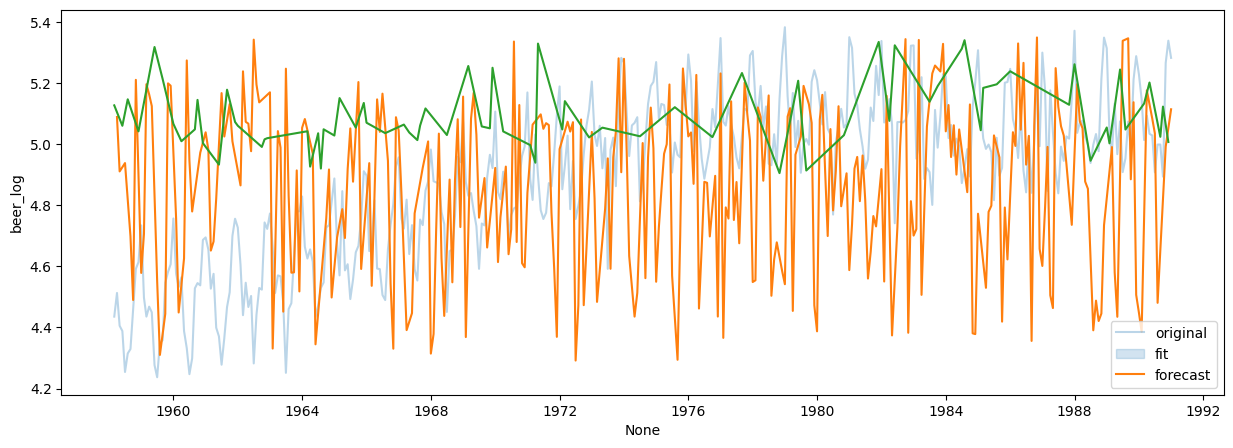

In [64]:
start_idx = 1
train_idx = X_train.reset_index().index[start_idx:]
n_periods = len(X_test)

sns.lineplot(x=CBE.index, y=CBE['beer_log'], alpha = 0.3)
sns.lineplot(x=X_train.index[train_idx],y= best_fit.predict_in_sample(start = start_idx, end = train_idx.max()))
sns.lineplot(x=X_test.index,y= best_fit.predict(n_periods = n_periods))
plt.legend(['original', 'fit', 'forecast']);

Notice how the predictions are initially a bit off, but overall the forecasts look reasonable.

- Compute the RMSE and use `plot_ts_resid` to plot the line plot and the histogram of the residuals. How does the RMSE for this model compare the the linear regression model? <span style="color:red" float:right></span>

y_true shape: (79,)
y_pred shape: (79,)
Test RMSE: 128.03


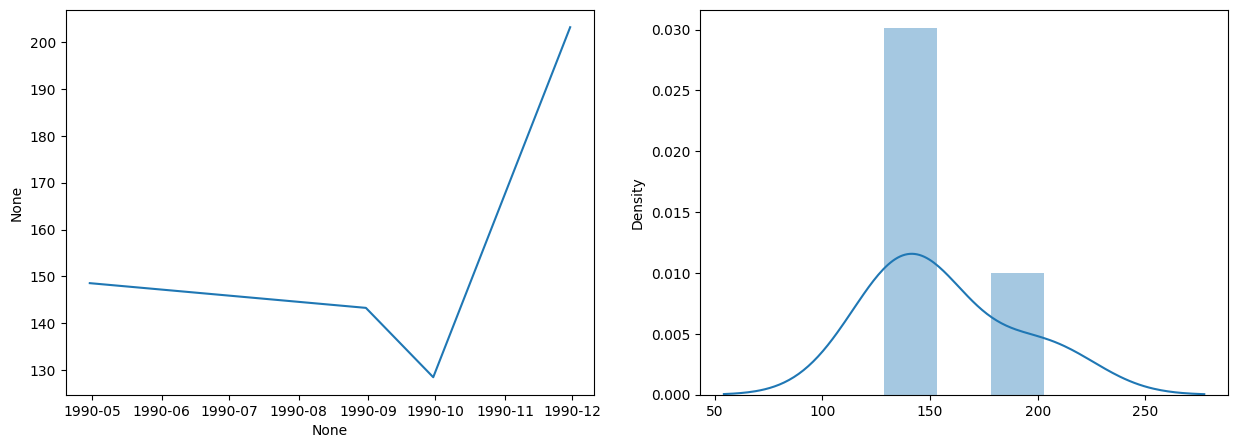

In [73]:
## your code goes here
forecast = best_fit.predict(n_periods=n_periods)
print(f"y_true shape: {y_test.shape}")
print(f"y_pred shape: {forecast.shape}")

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, forecast))
print(f'Test RMSE: {rmse:.2f}')

res=y_test-forecast
plot_ts_resid(res)